In [1]:
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.utils.data
import numpy as np
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import pandas as pd
from math import sin, cos
from PIL import ImageDraw, Image
import cv2
sys.path.append(os.path.abspath("./Residual-Attention-Network/"))
import seaborn as sns
import cv2
import time
import sklearn.preprocessing
from tqdm.notebook import tqdm
import torch.nn as nn
from sklearn.linear_model import LinearRegression
import torchvision
from torchvision.models import resnet18
import glob
import torch.nn.functional as F
np.set_printoptions(precision=2, suppress=True) 
%autosave 60

Autosaving every 60 seconds


In [2]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x
def pad_img(img, size = (112, 112, 3)):
    padded_img = np.zeros(size)
    pad_center_y = size[0]/2
    pad_center_x = size[1]/2
    if img.shape[0]>img.shape[1]:
        newwidth = int(img.shape[1]/img.shape[0]*size[0]//2*2)
        img = cv2.resize(img, (newwidth, size[0]))
        padded_img[:, int(pad_center_x-newwidth//2):int(pad_center_x+newwidth//2)] = img
    else:
        newheight = int(img.shape[0]/img.shape[1]*size[1]//2*2)
        img = cv2.resize(img, (size[1], newheight))
        padded_img[int(pad_center_y-newheight//2):int(pad_center_y+newheight//2), :] = img
    return padded_img
def get_numpy_mesh(shape_y, shape_x, box):
    mesh = np.zeros([shape_y, shape_x, 2])
    
    xmax, ymax, xmin, ymin = box
    mg_y, mg_x = np.meshgrid(np.linspace(ymin, ymax, shape_y), np.linspace(xmin, xmax, shape_x), indexing = 'ij')
    mesh[:, :, 0] = mg_y
    mesh[:, :, 1] = mg_x
    return mesh.astype('float32')
class stage2Dataset(torch.utils.data.Dataset):
    def __init__(self, mode = 'train'):
        super(stage2Dataset, self)
        self.df = pd.read_csv('./Joseph_Dataset/cropped_rcnn_annotations.csv')
#         self.means = {}
#         self.stds = {}
#         keys = ['x', 'y', 'z']
#         for key in keys:
#             self.means[key] = np.mean(df[key])
#             self.stds[key] = np.std(df[key])
        if mode == 'train':
            self.df = self.df[:int(len(self.df)*0.7)]  
        else:
            self.df = self.df[int(len(self.df)*0.7):]   
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        dic = dict(self.df.iloc[idx])
        keys = ['pred_filename','xmin', 'xmax', 'xcenter', 'ymin', 'ymax', 'ycenter', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']
        pred_filename, xmin, xmax, xcenter, ymin, ymax, ycenter, yaw, pitch, roll, x, y, z = [dic[key] for key in keys]
        img = plt.imread(pred_filename).astype('float32')/255
#         img_copy = img.copy() 
        height, width, channels = img.shape
        mesh = get_numpy_mesh(height, width,[xmax/3384, ymax/2710, xmin/3384, ymin/2710])
        img = np.concatenate([img, mesh], axis = 2)
        img = pad_img(img, size = (112, 112, 5))
        img = img.transpose((2, 0, 1))
        xmiddle = (xmax+xmin)/2
        ymiddle = (ymax+ymin)/2
        xcenter = (xcenter-xmiddle)/(max(xmax-xmin, ymax-ymin)/2)
        ycenter = (ycenter-ymiddle)/(max(ymax-ymin, ymax-ymin)/2)
        
        
        ## recover the point, visualize it, whatever you call it
#         longerside = max(xmax-xmin, ymax-ymin)
#         xmiddle = (xmax+xmin)/2
#         ymiddle = (ymax+ymin)/2
#         xcenter = xmiddle+longerside/2*xcenter
#         ycenter = ymiddle+longerside/2*ycenter
#         img_copy = cv2.circle(img_copy, (int(xcenter-xmin), int(ycenter-ymin)), 3, (0, 1, 0), -1)
#         plt.imshow(img_copy)
        return img.astype('float32'),  (np.array([np.cos(yaw)>0, np.sin(yaw)*np.round(np.cos(yaw)), pitch, rotate(roll, np.pi), xcenter, ycenter])).astype('float32')

stage2set = stage2Dataset(True)
trainloader = torch.utils.data.DataLoader(stage2set, batch_size=128, shuffle = True)
stage2set[2]
pass


In [3]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
import numpy as np
from model.basic_layers import ResidualBlock
from model.attention_module import AttentionModule_stage1, AttentionModule_stage2, AttentionModule_stage3, AttentionModule_stage0
from model.attention_module import AttentionModule_stage1_cifar, AttentionModule_stage2_cifar, AttentionModule_stage3_cifar
class ResidualAttentionModel_56(nn.Module):
    # for input size 224
    def __init__(self):
        super(ResidualAttentionModel_56, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.residual_block1 = ResidualBlock(64, 256)
        self.attention_module1 = AttentionModule_stage1(256, 256)
        self.residual_block2 = ResidualBlock(256, 512, 2)
        self.attention_module2 = AttentionModule_stage2(512, 512)
        self.residual_block3 = ResidualBlock(512, 1024, 2)
        self.attention_module3 = AttentionModule_stage3(1024, 1024)
        self.residual_block4 = ResidualBlock(1024, 2048, 2)
        self.residual_block5 = ResidualBlock(2048, 2048)
        self.residual_block6 = ResidualBlock(2048, 2048)
        self.mpool2 = nn.Sequential(
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=7, stride=1)
        )
        self.fc = nn.Linear(2048,7)

    def forward(self, x):
        out = self.conv1(x)
        out = self.mpool1(out)
        # print(out.data)
        out = self.residual_block1(out)
        out = self.attention_module1(out)
        out = self.residual_block2(out)
        out = self.attention_module2(out)
        out = self.residual_block3(out)
        # print(out.data)
        out = self.attention_module3(out)
        out = self.residual_block4(out)
        out = self.residual_block5(out)
        out = self.residual_block6(out)
        out = self.mpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

In [4]:
# def get_mesh(batch_size, shape_y, shape_x, box_specs):
#     mesh = torch.zeros([batch_size, 2, shape_y, shape_x])
#     for i in range(batch_size):
#         xmax, ymax, xmin, ymin = box_specs[i].detach().numpy()
#         mg_y, mg_x = np.meshgrid(np.linspace(ymin, ymax, shape_y), np.linspace(xmin, xmax, shape_x), indexing = 'ij')
#         mesh[i, 0, :, :] = torch.Tensor(mg_y)
#         mesh[i, 1, :, :] = torch.Tensor(mg_x)
#     return mesh

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=3):
        self.inplanes = 64 #64
        super(ResNet, self).__init__()
#        self.simplemodel = reallysimplemodel()
        self.conv1 = nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn0 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.selu = nn.SELU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0]) #64
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2) #128
        self.attention_module3 = AttentionModule_stage3(128, 128)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2) #256
        self.attention_module4 = AttentionModule_stage3(256, 256, (7, 7))
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2) #512
        self.avgpool = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(8192 * block.expansion, 200)
        self.fc1 = nn.Linear(200, 6)
        #self.bn1 = nn.BatchNorm1d(300)
#         self.fc2 = nn.Linear(300, 500)
#         self.bn2 = nn.BatchNorm1d(500)
#         self.fc3 = nn.Linear(500, 300)
#         self.bn3 = nn.BatchNorm1d(300)
#         self.fc4 = nn.Linear(300, 200)
#         self.bn4 = nn.BatchNorm1d(200)
#         self.fc5 = nn.Linear(200, 200)
#         self.bn5 = nn.BatchNorm1d(200)
        #self.fc6 = nn.Linear(300, 3)
        self.relu = nn.ReLU()
        self.selu = nn.SELU()
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        ## to compensate for the meshgrid for next round
        #self.inplanes += 2
        return nn.Sequential(*layers)
    def forward(self, x):
        #batch_size = len(box_specs)
        #mesh = get_mesh(batch_size, x.shape[2], x.shape[3], box_specs)
        #x = torch.cat([x, mesh], dim = 1)
        
        
        x = self.conv1(x)    # 224x224
        x = self.bn0(x)     
        x = self.relu(x)
        x = self.maxpool(x)  # 112x112
        
        #mesh = get_mesh(batch_size, x.shape[2], x.shape[3], box_specs)
        #x = torch.cat([x, mesh], 1)
        
        
        
        x = self.layer1(x)   # 56x56
        #mesh = get_mesh(batch_size, x.shape[2], x.shape[3], box_specs)
        #x = torch.cat([x, mesh], 1)
        
        
        x = self.layer2(x)   # 28x28
        x = self.attention_module3(x)

        #mesh = get_mesh(batch_size, x.shape[2], x.shape[3], box_specs)
        #x = torch.cat([x, mesh], 1)
        
        
        
        x = self.layer3(x)   # 14x14
        x = self.attention_module4(x)
        #mesh = get_mesh(batch_size, x.shape[2], x.shape[3], box_specs)
        #x = torch.cat([x, mesh], 1)
        
        x = self.layer4(x)   # 7x7
        #mesh = get_mesh(batch_size, x.shape[2], x.shape[3], box_specs)
        #x = torch.cat([x, mesh], 1)
        #x = self.avgpool(x)  # 1x1
        x = x.view(x.size(0), -1)
        X = self.relu(self.fc(x))
        X = self.fc1(X)
        return X

class reallysimplemodel(nn.Module):
    def __init__(self):
        super(reallysimplemodel, self).__init__()
        self.fc1 = nn.Linear(8, 300)
        self.fc2 = nn.Linear(300, 500)
        self.fc3 = nn.Linear(500, 300)
        self.fc4 = nn.Linear(300, 200)
        self.fc5 = nn.Linear(200, 200)
        self.fc6 = nn.Linear(200, 3)
        self.relu = nn.ReLU()
        self.selu = nn.SELU()
    def forward(self, X):
#         X1 = torch.Tensor(X)
#         X1[:, 0] = X[:, 0]/2+X[:, 2]/2
#         X1[:, 1] = X[:, 1]/2+X[:, 3]/2
#         X1[:, 2] = X[:, 0]-X[:, 2]
#         X1[:, 3] = X[:, 1] - X[:, 3]
        X1 = self.relu(self.fc1(X))
        X = self.fc2(X1)
        X = self.relu(self.fc3(X))
        X += X1
        X = self.fc4(X)
        X = self.selu(self.fc5(X))
        out = self.fc6(X)
        return out
            
# inp = k.layers.Input(shape=(4,))
# h1 = k.layers.Dense(300, activation='relu')(inp)
# h = k.layers.Dense(500, activation='selu')(h1)
# h = k.layers.Dense(300, activation='relu')(h)
# h += h1 #residue
# h = k.layers.Dense(200, activation='relu')(h)
# h = k.layers.Dense(200, activation='selu')(h)
# out = k.layers.Dense(3, activation='linear')(h)

In [24]:
bestaccuracy = 0.9
net = ResNet(BasicBlock, [3, 3, 4, 3]).to('cuda') #[2,2,2,2]
net.train()
for parameter in net.parameters():
    if len(parameter.shape)>1:
        torch.nn.init.xavier_uniform_(parameter)
#net.load_state_dict(torch.load('./Joseph_Dataset/weights/last_attention.pth'))
stage2set = stage2Dataset('train')
trainloader = torch.utils.data.DataLoader(stage2set, batch_size=64, shuffle = True) 
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.0001) 
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 0.000001, 0.0001, step_size_up = 200, mode = 'triangular2', cycle_momentum=False, last_epoch = -1)
L1 = torch.nn.L1Loss()
BCE = torch.nn.BCEWithLogitsLoss()

In [ ]:
for epoch in range(50):
    running_accuracy = []
    idx = 0
    for (images, targets) in tqdm(trainloader):
        images, targets = images.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = net(images)
        clsloss = BCE(outputs[:, 0], targets[:, 0])
        regloss = L1(outputs[:, 1:], targets[:, 1:])
        loss = clsloss + regloss
        cls_preds = np.greater(outputs[:,0].cpu().detach().numpy(), 0)
        cls_truth = targets[:,0].cpu().detach().numpy()
        correctness = np.equal(cls_preds, cls_truth).astype(int)
        accuracy = sum(correctness)/64
        running_accuracy.append(accuracy)
        running_accuracy = running_accuracy[-10:]
        print(' clsloss '+str(clsloss.cpu().detach().numpy())[:4]+' regloss '+str(regloss.cpu().detach().numpy())[:4]+
              ' accuracy '+str(np.mean(running_accuracy)), end = '\r')
        if np.mean(running_accuracy)>bestaccuracy:
            bestloss = np.mean(running_accuracy)
            torch.save(net.state_dict(), './Joseph_Dataset/weights/best_attention.pth')
            #print('totalloss', str(loss.detach().numpy())[:4], 'saved!', end = '\n')
        else:
            pass
            #print('totalloss', str(loss.detach().numpy())[:4]+' ', end = '\n')
        loss.backward()
        optimizer.step()
        scheduler.step()
        #if idx%5==0:
        #    print('\n', outputs[0].cpu().detach().numpy(), targets[0].cpu().detach().numpy(), '\n')
        #idx+=1
    torch.save(net.state_dict(), './Joseph_Dataset/weights/last_attention.pth')

    print(epoch)

 clsloss 0.39 regloss 0.17 accuracy 0.78125553333333335
0


 clsloss 0.24 regloss 0.13 accuracy 0.8078125555555556
1


 clsloss 0.41 regloss 0.12 accuracy 0.8531255222222222
2


 clsloss 0.24 regloss 0.16 accuracy 0.8906255777777778
3


 clsloss 0.20 regloss 0.14 accuracy 0.9109375666666666
4


## Validate angle model

In [22]:
stage2valset = stage2Dataset('test')
stage2valloader = torch.utils.data.DataLoader(stage2valset, batch_size=64, shuffle = True) 
L1 = torch.nn.L1Loss()
BCE = torch.nn.BCEWithLogitsLoss()

In [23]:
for epoch in range(50):
    running_accuracy = []
    idx = 0
    for (images, targets) in tqdm(stage2valloader):
        images, targets = images.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = net(images)
        clsloss = BCE(outputs[:, 0], targets[:, 0])
        regloss = L1(outputs[:, 1:], targets[:, 1:])
        loss = clsloss + regloss
        cls_preds = np.greater(outputs[:,0].cpu().detach().numpy(), 0)
        cls_truth = targets[:,0].cpu().detach().numpy()
        correctness = np.equal(cls_preds, cls_truth).astype(int)
        accuracy = sum(correctness)/64
        running_accuracy.append(accuracy)
        running_accuracy = running_accuracy[-10:]
        print(' clsloss '+str(clsloss.cpu().detach().numpy())[:4]+' regloss '+str(regloss.cpu().detach().numpy())[:4]+
              ' accuracy '+str(np.mean(running_accuracy)), end = '\r')

    print(epoch)

KeyboardInterrupt: 

## Global xyz estimation

In [ ]:
from efficientnet_pytorch import EfficientNet
class BackBone(nn.Module):
    def __init__(self, block, layers, num_classes=3):
        self.inplanes = 64 #64
        super(BackBone, self).__init__()
#        self.simplemodel = reallysimplemodel()
        self.conv1 = nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn0 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.selu = nn.SELU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0]) #64
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2) #128
        self.attention_module3 = AttentionModule_stage3(128, 128)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2) #256
        self.attention_module4 = AttentionModule_stage3(256, 256, (7, 7))
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2) #512

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)    # 224x224
        x = self.bn0(x)     
        x = self.relu(x)
        x = self.maxpool(x)  # 112x112   
        x = self.layer1(x)   # 56x56
        x = self.layer2(x)   # 28x28
        x = self.attention_module3(x)
        x = self.layer3(x)   # 14x14
        x = self.attention_module4(x)
        x = self.layer4(x)   # 7x7
        return x
    
    
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [ ]:
class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = net = BackBone(BasicBlock, [3, 4, 6, 3]).to('cuda')
        
        self.conv0 = double_conv(6, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 + 1024, 512)
        self.up2 = up(512 + 512, 256)
        self.up3 = up(256+128, 128)
        self.up4 = up(128+64, 64)
        self.up5 = up(64+6, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)
 
    def forward(self, x):
        masks = x[:, 3:4, :, :]
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        x_center = x[:, :3, :, IMG_WIDTH // 8: -IMG_WIDTH // 8]
        feats = self.base_model.extract_features(x_center)
        bg = torch.zeros([feats.shape[0], feats.shape[1], feats.shape[2], feats.shape[3] // 8]).to(device)
        feats = torch.cat([bg, feats, bg], 3)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, feats.shape[2], feats.shape[3])
        feats = torch.cat([feats, mesh2], 1)
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.up5(x, x0)
        x = self.outc(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
xyzmodel = MyUNet(3).to(device)
bestaccuracy = 0.5
xyzmodel.load_state_dict(torch.load('./Joseph_Dataset/xyzmodel.pth'))

In [ ]:
k = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
IMG_WIDTH = 448
IMG_HEIGHT = 128
# def imread(path, fast_mode=False):
#     img = cv2.imread(path)
#     if not fast_mode and img is not None and len(img.shape) == 3:
#         img = np.array(img[:, :, ::-1])
#     return img
def make_input_output(filename, df, shape_y = IMG_HEIGHT, shape_x = IMG_WIDTH, cutoff_y = 1600):
    padding_x = 3384//6
    img = np.zeros((2710, 3384+padding_x*2, 3), dtype = 'float32')
    img[:, padding_x:-padding_x, :] = plt.imread(filename).astype('float32')/255
    mask = np.zeros((img.shape[0], img.shape[1], 1), dtype = 'float32')
    output = np.zeros((img.shape[0], img.shape[1], 3), dtype = 'float32')
    df = df[df['original_name'] == filename]
    xcenters, ycenters, xs, ys, zs = df[['xcenter', 'ycenter', 'x', 'y', 'z']].values.T
    input_tensor = np.concatenate([img, mask], axis = 2)
    input_tensor, output = input_tensor[cutoff_y:], output[cutoff_y:]
    input_tensor = cv2.resize(input_tensor, (shape_x, shape_y))
    target = cv2.resize(output, (shape_x, shape_y))
    out_mask = cv2.resize(input_tensor[:, :, 3], (shape_x, shape_y))[:, :, np.newaxis]
    for xcenter, ycenter, x, y, z in zip(xcenters, ycenters, xs, ys, zs):
        if xcenter<-padding_x or xcenter>3384+padding_x or ycenter<0 or ycenter>2710:
            print('fuck')# if result is too ridiculous
            continue
        xcenter = (xcenter+padding_x)/(3384+padding_x*2)*shape_x
        ycenter = (ycenter-cutoff_y)/(2710-cutoff_y)*shape_y
        input_tensor[int(ycenter), int(xcenter), 3] = 1
        target[int(ycenter), int(xcenter)] = np.array([x, y, z])/100
        out_mask[int(ycenter), int(xcenter)] = 1
    return input_tensor.astype('float32'), target.astype('float32'), out_mask.astype('float32')
class xyzDataset(torch.utils.data.Dataset):
    def __init__(self, mode = 'train'):
        super(xyzDataset, self)
        self.df = pd.read_csv('./Joseph_Dataset/cropped_rcnn_annotations.csv')
        self.filenames = glob.glob('./train_images/*.jpg')
#         self.means = {}
#         self.stds = {}
#         keys = ['x', 'y', 'z']
#         for key in keys:
#             self.means[key] = np.mean(df[key])
#             self.stds[key] = np.std(df[key])
        if mode == 'train':
            self.filenames = self.filenames[:int(len(self.filenames)*0.7)]  
        else:
            self.filenames = self.filenames[int(len(self.filenames)*0.7):]   

    def __len__(self):
        return len(self.filenames)
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        input_tensor, output, out_mask = make_input_output(filename, self.df)
        return input_tensor.transpose((2, 0, 1)), output.transpose((2, 0, 1)), out_mask.transpose((2, 0, 1))
xyzset = xyzDataset()
#plt.figure(figsize = (30, 20))
#plt.imshow(xyzset[0][0].transpose((1, 2, 0))[:, :, :3]/2+(1-xyzset[0][0].transpose((1, 2, 0))[:, :, 3:4])/2)
#plt.figure(figsize = (30, 20))
#plt.imshow(1-xyzset[0][0].transpose((1, 2, 0))[:, :, 3])
plt.figure(figsize = (30, 20))
plt.imshow(xyzset[0][2].transpose((1, 2, 0))[:, :, 0])


In [134]:
xyzset = xyzDataset()
trainloader = torch.utils.data.DataLoader(xyzset, batch_size=4, shuffle = True, num_workers = 4)
optimizer = torch.optim.AdamW(xyzmodel.parameters(), lr = 0.0001) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma = 0.3, step_size= 200, last_epoch = -1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 0.000001, 0.0001, step_size_up = 200, mode = 'triangular2', cycle_momentum=False, last_epoch = -1)

In [135]:
L1 = torch.nn.L1Loss(size_average = False)
for epoch in range(50):
    for (images, targets, out_masks) in tqdm(trainloader):
        images = images.to(device)
        targets = targets.to(device)
        out_masks = out_masks.to(device)
        optimizer.zero_grad()
        outputs = xyzmodel(images)
        loss = L1(outputs*out_masks, targets*out_masks)/4
        outputs = (outputs*out_masks).cpu().detach().numpy()  
        targets = (targets*out_masks).cpu().detach().numpy()
        if np.mean(np.linalg.norm(targets*100, axis = 1))>0:
            truth_norm = np.linalg.norm(targets*100, axis = 1).flatten()
            error_norm = np.linalg.norm(outputs*100-targets*100, axis = 1).flatten()
            truth_norm, error_norm = truth_norm[truth_norm>0], error_norm[error_norm>0]
            accuracy = sum((error_norm/truth_norm)<0.1)/len(error_norm)
            print('mean error', np.mean(error_norm/truth_norm), 'accuracy', accuracy, end = '\t')
        print('L1loss', loss.cpu().detach().numpy(), end = '\r')
        if accuracy>bestaccuracy:
            bestaccuracy = accuracy
            torch.save(xyzmodel.state_dict(), './Joseph_Dataset/xyzmodel.pth')
        loss.backward()
        optimizer.step()
        scheduler.step()
    print(epoch)

/home/paperspace/.local/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


mean error 0.10978034 accuracy 0.5483870967741935	L1loss 0.4737703454
0


KeyboardInterrupt: 

183.0676304161126 19.15073198198198
203.23165828623672 21.778490990990992
154.06951687860152 24.743848536036037
147.62217333638077 24.77019988738739
238.5821818899601 21.56138795045045
136.24509467808065 22.98745777027027
164.43753116688828 27.977407094594593
85.527053291916 33.993989301801804
184.1717555269282 31.510796734234233
353.479904283023 49.40184403153153


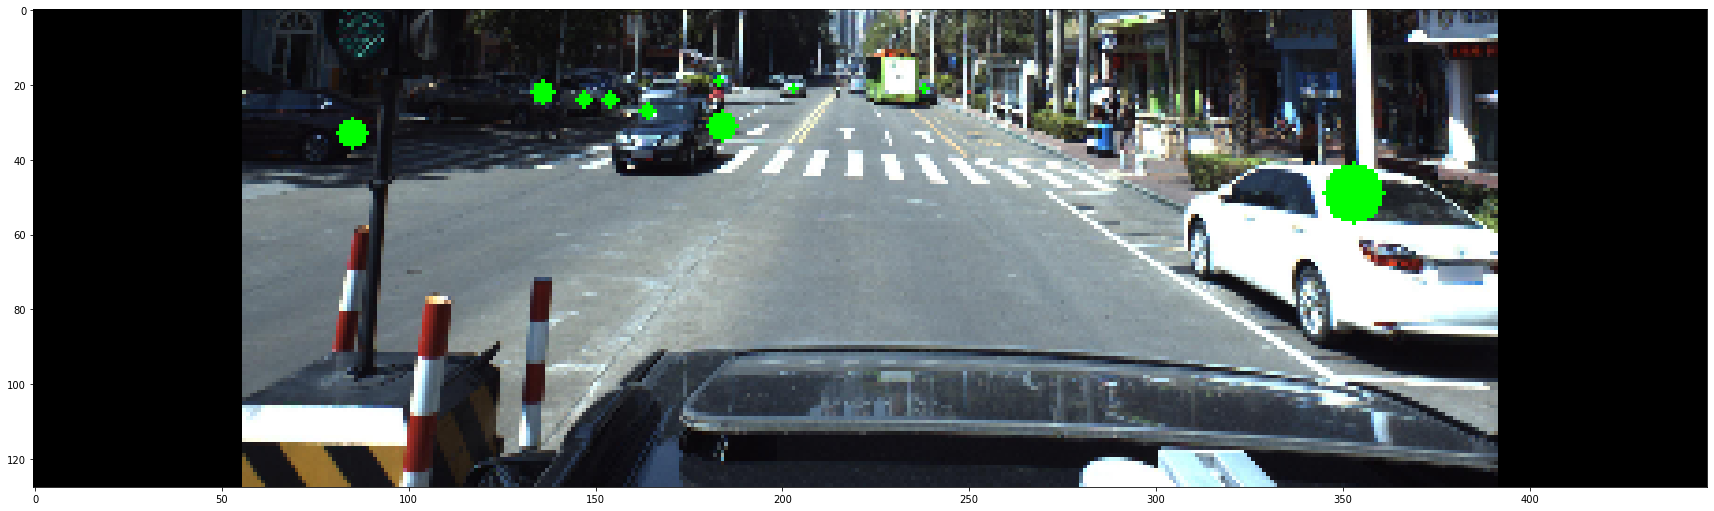

In [133]:
xyzmodel.load_state_dict(torch.load('./Joseph_Dataset/xyzmodel.pth'))
def project(x, y, z):
    camera_x, camera_y, camera_z = np.dot(k, [x, y, z])
    return camera_x/camera_z, camera_y/camera_z
input_tensor, target, output_mask = iter(trainloader).next()
input_tensor = input_tensor[0:1]
output_mask = output_mask[0].cpu().detach().numpy().transpose((1, 2, 0))
output = xyzmodel(input_tensor.to('cuda'))
img = input_tensor[0].detach().numpy().transpose((1, 2, 0))[:, :, :3]
output = output[0].cpu().detach().numpy().transpose((1, 2, 0))*output_mask
for i in range(output_mask.shape[0]):
    for j in range(output_mask.shape[1]):
        if output_mask[i][j]!=0:
            x, y, z = output[i][j]*100
            img_x, img_y = project(x, y, z)
            xcenter = (img_x+3384//6)/(3384+3384//6*2)*IMG_WIDTH
            ycenter = (img_y-1600)/(2710-1600)*IMG_HEIGHT
            print(xcenter, ycenter)
            img = cv2.circle(img, (int(xcenter), int(ycenter)), int(100/z), (0, 1, 0), -1)
plt.figure(figsize = (30, 20))
plt.imshow(img.get())

In [ ]:
#net = torch.load('./Joseph_Dataset/weights/net.pth')
#visualize
k = np.array([[2304.5479, 0,  1686.2379],
           [0, 2305.8757, 1354.9849],
           [0, 0, 1]], dtype = np.float32)
testfile = './train_images/ID_a381bf4d0.jpg'
image = plt.imread(testfile)
filenames, xmin, xmax, xcenter, ymin, ymax, ycenter, x, y, z = df.loc[df['original_name']==testfile][['cropped_filename','xmin','xmax', 'xcenter', 'ymin','ymax', 'ycenter', 'x', 'y', 'z']].values.T
predictors = np.zeros((len(xmin), 4))
predictors[:, 0] = xmax.astype(int)/3384
predictors[:, 1] = ymax.astype(int)/2710
predictors[:, 2] = xmin.astype(int)/3384
predictors[:, 3] = ymin.astype(int)/2710
images = np.zeros((len(filenames), 3, 112, 112))
for i, filename in enumerate(filenames):
    img = plt.imread(filename)
    img = cv2.resize(img, (112, 112))
    img = img.astype('float32').transpose((2, 0, 1))/255
    images[i] = img
images = torch.Tensor(images)
preds = net(images, torch.Tensor(predictors)).detach().numpy().astype('float32')
preds = preds*100
camera_xyz = np.dot(k, preds.T).T
camera_xyz[:, 0]/=camera_xyz[:, 2]
camera_xyz[:, 1]/=camera_xyz[:, 2]
img_xyz = camera_xyz[:, :2]
print(img_xyz.shape)
for [p_x, p_y] in img_xyz:
    cv2.circle(image, (int(p_x), int(p_y)), 5, (255, 0, 0), -1)
plt.figure(figsize = (30, 20))
plt.imshow(image)